Following Python jupyter notebook presents the workflow for generation of synthetic earthquake catalogs for Null and alternative hypotheses as described in *Synthetic earthquake catalogs* Section of the Chapter 4.

It takes following inputs:

1. hf_wells = catalog of hydraulic fractuuring wells with defined latitude/longitude coordinates, values of Seismogenic Activation Potential at well location
2. eqsRaw = observed seismicity catalog with latitude/longitude coordinates and magnitude values

It can be run in Jupyter notebook or Jupyter Lab (https://jupyter.org/).

In [42]:
# Load libraries

import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
import math 
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns

import random
import os

import time, os, fnmatch, shutil

import warnings
from pandas.core.common import SettingWithCopyWarning

random.seed(15)

In [43]:
# Define functions

""" Calculate Seismic Moment from Moment Magnitude""" 
def calc_seismic_moment(momentMag):
    
    seismMoment = pow(10, (3/2 * momentMag+16.0))
    seismMoment = seismMoment / 10000000 # to convert to Newton-meter 
    
    return seismMoment

"""generate magnitudes script"""
def generate_magnitudes(magnitude_of_completeness, b_value, no_of_events):
    alpha = b_value + 1 
    
    x_min = 10**(magnitude_of_completeness)
    x_max = 1e5
    
    x = np.random.uniform(low=x_min,high= x_max , size = no_of_events)
    
    p_x =  x ** (-1 / (alpha - 1)) #((alpha - 1) / x_min) * (x / x_min) ** -alpha
    
    magnitudes = np.log10(p_x) + np.abs(np.min(np.log10(p_x))) + magnitude_of_completeness
    
    return magnitudes


"""calculate location of the earthquake using randomly assigned radius and azimuth"""
def calc_eq_coords(lon, lat, R, azi):
    
    eqLoc = geopy.distance.geodesic(kilometers=R).destination((lat, lon), bearing=azi)
    
    return eqLoc

In [44]:
# Load the files

hf_wells = pd.read_csv("data/INPUT_WELLS_SAP.csv", usecols=['Bot-Hole Lon','Bot-Hole Lat','geometry','SAP'])

wells_gdf = gpd.GeoDataFrame(
    hf_wells, geometry=gpd.points_from_xy(hf_wells['Bot-Hole Lon'], hf_wells['Bot-Hole Lat']), crs='epsg:4326')

wells_gdf = wells_gdf.rename(columns={'Bot-Hole Lat':'BotHLat',
                  'Bot-Hole Lon':'BotHLon'})

wells_gdf = wells_gdf.to_crs(26910)
wells_gdf['easting'] = wells_gdf.geometry.x
wells_gdf['northing'] = wells_gdf.geometry.y

eqsRaw = pd.read_csv('data/compiled_eq_NRCanAER_KSMMA_NPGMMA_AB.csv')
eqsRaw = eqsRaw[eqsRaw['mag'] >= 1]
eqsDf = gpd.GeoDataFrame(
    eqsRaw, geometry=gpd.points_from_xy(eqsRaw['lon'], eqsRaw['lat']), crs='epsg:4326')
realEQs = eqsDf.to_crs(26910)
realEQnumber = realEQs.shape[0] 
print('Number of events above M1 in observed catalogue: ', realEQnumber)

C:\Users\Paulina-laptop\AppData\Roaming\Python\Python37\site-packages\geopandas\array.py:253: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Number of events above M1 in observed catalogue:  9754


In [45]:
"""
create_synt_EQdf_testH0:
1. DO NOT assign seismogenic wells [ if we want, we can select 3% of all wells too by using df.sample[frac=0.03]. 
Otherwise, each wells is similarily likely to induce EQ]
2. OUTPUT = EQ catalogue with synthetic EQ within 15% of Montney wells
"""

def create_synt_EQdf_testH0(realEQnumber, wells_df, scale):
  
    seismoWells = wells_df.sample(frac=0.15) # select 15% of seismogenic wells by random (n = 1291)

    seismoWells = seismoWells.reset_index(drop=True)
 
    ### Assign number of events to each seismogenic well
    seismoWells['numEq'] = np.random.default_rng().exponential(scale=scale, size=seismoWells.shape[0]) 
    seismoWells['numEq'] = np.rint(seismoWells['numEq']).astype(int)
    
    ### Create empty dataframe to save the results
    allEQs = pd.DataFrame(columns=['wellNr','wellLon','wellLat','eqLon','eqLat', 'eqNr'])

    ### Loop through wells to have each EQ in separate row 
    for well_idx, well in seismoWells.iterrows():
        
        oneWellDf = pd.DataFrame(columns=['wellNr','wellLon','wellLat','eqLon','eqLat', 'eqNr'])
        
        for i in range(well.numEq):

            oneWellDf.loc[i, 'wellNr'] = well_idx
            oneWellDf.loc[i, 'wellLat'] = well.BotHLat
            oneWellDf.loc[i, 'wellLon'] = well.BotHLon
            oneWellDf.loc[i, 'wellNr'] = well_idx
            oneWellDf.loc[i, 'eqNr'] = i
        allEQs = allEQs.append(oneWellDf)

    ### Select exactly N rows (N = number of EQs M>1 in observed catalogue)
    allEQs= allEQs.sample(n = realEQnumber)
    allEQs = allEQs.reset_index(drop=True)

    ### assign random R and azi for each earthquake to locate it around random well
    allEQs.loc[:,'R'] = np.random.default_rng().exponential(size = allEQs.shape[0])
    allEQs.loc[:,'azi'] = np.random.default_rng().uniform(low=0.0, high=360.0, size = allEQs.shape[0])
    
    ### generate synthetic magnitudes; calculate seismic moment 
    allEQs.loc[:,'mag'] = generate_magnitudes(1, 1, realEQnumber)
    allEQs.loc[:,'M0Synt'] = allEQs.apply(lambda x: calc_seismic_moment(x['mag']), axis=1)
    allEQs['M0Synt'] = np.where(allEQs['mag'] >= 2, allEQs['M0Synt'],0) # mask M0 from events <M2

    ### calculate synthetic EQ location
    allEQs.loc[:,'syntLoc'] = allEQs.apply(lambda x: calc_eq_coords(x['wellLon'], x['wellLat'], x['R'], x['azi']), axis=1)
    allEQs.loc[:,'eqLat']= allEQs.apply(lambda x: x['syntLoc'].latitude, axis=1)
    allEQs.loc[:,'eqLon']= allEQs.apply(lambda x: x['syntLoc'].longitude, axis=1)

    ### Create geodataframe from synthetic earhquakes 
    allEQs_gdf = gpd.GeoDataFrame(
        allEQs, geometry=gpd.points_from_xy(allEQs['eqLon'], allEQs['eqLat']), crs='epsg:4326')
    allEQsUTM = allEQs_gdf.to_crs(26910)
    
    ### export synthetic catalogue
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    catName = ("EQcat-" + timestamp + '.csv') 
    
#     allEQsUTM.to_csv('results/simulatedCatalogues/testH0/' + catName)

     
    return allEQsUTM

In [46]:
"""
create_synt_EQdf_testA:
1. Assigns seismogenic wells by comparing Seismogenic Activation Value for all wells with SAP from Wozniakowska & Eaton, 2020
2. OUTPUT = EQ catalogue with synthetic EQ within seismogenic wells where SAV < SAP
"""

def create_synt_EQdf_testA(realEQnumber, wells_df, scale):
    
    wells_df.loc[:,'SAV'] = (1 - 0) * np.random.random_sample(size=wells_df.shape[0]) + 0 # assign SAV from rand.distr (0,1)
    wells_df.loc[:,'flag'] = np.where(wells_df['SAV'] < wells_df['SAP'], True, False) 

    wells_df.loc[:,'flagSAP1'] = np.where(wells_df['SAV'] < wells_df['SAP'], True, False) # check if SAV < SAP
    wells_df.loc[:,'flagSAP2'] = np.where(wells_df['SAV'] < 0.2, False, True) # set minimum SAV threshold
    seismoWells = wells_df[(wells_df["flagSAP1"] == True) | (["flagSAP2"] == True)]

    # ensure we use exactly 1291 wells = 15% of all wells
    if seismoWells.shape[0] > 1291:
        seismoWells = seismoWells.sample(n=1291)

    seismoWells = seismoWells.reset_index(drop=True)
    seismoWells['numEq'] = np.random.default_rng().exponential(scale=scale, size=seismoWells.shape[0]) 
    seismoWells['numEq'] = np.rint(seismoWells['numEq']).astype(int)
    
    allEQs = pd.DataFrame(columns=['wellLon','wellLat','wellEasting','wellNorthing','eqLon','eqLat', 'eqNr'])

    ### Loop through wells to have each EQ in separate row 
    for well_idx, well in seismoWells.iterrows():
        
        oneWellDf = pd.DataFrame(columns=['wellNr','wellLon','wellLat', 'eqNr'])
        
        for i in range(well.numEq):

            oneWellDf.loc[i, 'wellNr'] = well_idx
            oneWellDf.loc[i, 'wellLat'] = well.BotHLat
            oneWellDf.loc[i, 'wellLon'] = well.BotHLon
            oneWellDf.loc[i, 'eqNr'] = i
        
        allEQs = allEQs.append(oneWellDf)
    
    ### Select exactly N rows (N = number of EQs M>1 in observed catalogue)
    allEQs = allEQs.sample(n = realEQnumber)
    allEQs = allEQs.reset_index()
    
    ### assign random R and azi for each earthquake to locate it around random well
    allEQs.loc[:,'R'] = np.random.default_rng().exponential(size = allEQs.shape[0])
    allEQs.loc[:,'azi'] = np.random.default_rng().uniform(low=0.0, high=360.0, size = allEQs.shape[0])

    ### generate synthetic magnitudes; calculate seismic moment 
    allEQs.loc[:,'mag'] = generate_magnitudes(1, 1, realEQnumber)
    allEQs.loc[:,'M0Synt']= allEQs.apply(lambda x: calc_seismic_moment(x['mag']), axis=1)
    allEQs['M0Synt'] = np.where(allEQs['mag'] >= 2, allEQs['M0Synt'],0) # mask M0 from events <M2
    
    ### calculate synthetic EQ location
    allEQs.loc[:,'syntLoc'] = allEQs.apply(lambda x: calc_eq_coords(x['wellLon'], x['wellLat'], x['R'], x['azi']), axis=1)
    allEQs.loc[:,'eqLat']= allEQs.apply(lambda x: x['syntLoc'].latitude, axis=1)
    allEQs.loc[:,'eqLon']= allEQs.apply(lambda x: x['syntLoc'].longitude, axis=1)
    
    ### Create geodataframe from synthetic earhquakes 
    allEQs_gdf = gpd.GeoDataFrame(
        allEQs, geometry=gpd.points_from_xy(allEQs['eqLon'], allEQs['eqLat']), crs='epsg:4326')
    allEQsUTM = allEQs_gdf.to_crs(26910)

    ### Export synthetic catalogue
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    catName = ("EQcat-" + timestamp + '.csv') 
#     allEQsUTM.to_csv('results/simulatedCatalogues/testA/' + catName)

    return allEQsUTM



In [47]:
"""
create_synt_EQdf_testB:
1. Assigns seismogenic wells by selecting wells within structural corridors
2. OUTPUT = EQ catalogue with synthetic EQ within seismogenic wells which are located in Structural Corridors
"""

def create_synt_EQdf_testB(realEQnumber, wells_SC_df, scale):

    seismoWells = wells_SC_df.copy()
    # ensure we use exactly 1291 wells = 15% of all wells
    if seismoWells.shape[0] > 1291:
        seismoWells = seismoWells.sample(n=1291)

    seismoWells = seismoWells.reset_index(drop=True)

    # seismoWells['wellNr'] = seismoWells.index

    seismoWells['numEq'] = np.random.default_rng().exponential(scale=scale, size=seismoWells.shape[0]) 
    seismoWells['numEq'] = np.rint(seismoWells['numEq']).astype(int)

    allEQs = pd.DataFrame(columns=['wellLon','wellLat','wellEasting','wellNorthing','eqLon','eqLat', 'eqNr'])
    
    ### Loop through wells to have each EQ in separate row 
    for well_idx, well in seismoWells.iterrows():
        oneWellDf = pd.DataFrame(columns=['wellNr','wellLon','wellLat', 'eqNr'])
        
        for i in range(well.numEq):

            oneWellDf.loc[i, 'wellNr'] = well_idx
            oneWellDf.loc[i, 'wellLat'] = well.BotHLat
            oneWellDf.loc[i, 'wellLon'] = well.BotHLon
            oneWellDf.loc[i, 'eqNr'] = i
        allEQs = allEQs.append(oneWellDf)
    
    allEQs = allEQs.sample(n = realEQnumber)
    allEQs = allEQs.reset_index()

    allEQs.loc[:,'R'] = np.random.default_rng().exponential(size = allEQs.shape[0])
    allEQs.loc[:,'azi'] = np.random.default_rng().uniform(low=0.0, high=360.0, size = allEQs.shape[0])
    allEQs.loc[:,'mag'] = generate_magnitudes(1, 1, realEQnumber)

    allEQs.loc[:,'M0Synt']= allEQs.apply(lambda x: calc_seismic_moment(x['mag']), axis=1)
    allEQs['M0Synt'] = np.where(allEQs['mag'] >= 2, allEQs['M0Synt'],0) # mask M0 from events <M2

    allEQs.loc[:,'syntLoc'] = allEQs.apply(lambda x: calc_eq_coords(x['wellLon'], x['wellLat'], x['R'], x['azi']), axis=1)

    allEQs.loc[:,'eqLat']= allEQs.apply(lambda x: x['syntLoc'].latitude, axis=1)
    allEQs.loc[:,'eqLon']= allEQs.apply(lambda x: x['syntLoc'].longitude, axis=1)

    allEQs_gdf = gpd.GeoDataFrame(
        allEQs, geometry=gpd.points_from_xy(allEQs['eqLon'], allEQs['eqLat']), crs='epsg:4326')
    allEQsUTM = allEQs_gdf.to_crs(26910)

    ### export synthetic catalogue
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    catName = ("EQcat-" + timestamp + 'TESTPHD.csv') 
     
#     allEQsUTM.to_csv('results/simulatedCatalogues/testB/' + catName)


    return allEQsUTM



In [48]:
"""
create_synt_EQdf_testC:
1. Assigns seismogenic wells by only within structural corridors
2. OUTPUT = EQ catalogue with synthetic EQ within seismogenic wells which are located in Structural Corridors
"""

def create_synt_EQdf_testC(realEQnumber, wells_SC_df, scale):

    seismoWells = wells_SC_df.copy()

    seismoWells.loc[:,'SAV'] = (1 - 0) * np.random.random_sample(size=seismoWells.shape[0]) + 0 # assign SAV from rand.distr (0,1)
    seismoWells.loc[:,'flag'] = np.where(seismoWells['SAV'] < seismoWells['SAP'], True, False) 

    seismoWells.loc[:,'flagSAP1'] = np.where(seismoWells['SAV'] < seismoWells['SAP'], True, False) 
    seismoWells.loc[:,'flagSAP2'] = np.where(seismoWells['SAV'] < 0.2, False, True) 
    seismoWells = seismoWells[(seismoWells["flagSAP1"] == True) | (["flagSAP2"] == True)]

    ### Assign number of events to each seismogenic well
    seismoWells['numEq'] = np.random.default_rng().exponential(scale=scale, size=seismoWells.shape[0]) 
    seismoWells['numEq'] = np.rint(seismoWells['numEq']).astype(int)
    
    ### Create empty dataframe to save the results
    allEQs = pd.DataFrame(columns=['wellNr','wellLon','wellLat','eqLon','eqLat', 'eqNr'])

    ### Loop through wells to have each EQ in separate row 
    for well_idx, well in seismoWells.iterrows():
        oneWellDf = pd.DataFrame(columns=['wellNr','wellLon','wellLat','eqLon','eqLat', 'eqNr'])
        
        for i in range(well.numEq):

            oneWellDf.loc[i, 'wellNr'] = well_idx
            oneWellDf.loc[i, 'wellLat'] = well.BotHLat
            oneWellDf.loc[i, 'wellLon'] = well.BotHLon
            oneWellDf.loc[i, 'wellNr'] = well_idx
            oneWellDf.loc[i, 'eqNr'] = i
        allEQs = allEQs.append(oneWellDf)

    ### Select exactly N rows (N = number of EQs M>1 in observed catalogue)
    allEQs= allEQs.sample(n = realEQnumber)
    allEQs = allEQs.reset_index(drop=True)

    ### assign random R and azi for each earthquake to locate it around random well
    allEQs.loc[:,'R'] = np.random.default_rng().exponential(size = allEQs.shape[0])
    allEQs.loc[:,'azi'] = np.random.default_rng().uniform(low=0.0, high=360.0, size = allEQs.shape[0])
    
    ### generate synthetic magnitudes; calculate seismic moment 
    allEQs.loc[:,'mag'] = generate_magnitudes(1, 1, realEQnumber)
    allEQs.loc[:,'M0Synt'] = allEQs.apply(lambda x: calc_seismic_moment(x['mag']), axis=1)
    allEQs['M0Synt'] = np.where(allEQs['mag'] >= 2, allEQs['M0Synt'],0) # mask M0 from events <M2

    ### calculate synthetic EQ location
    allEQs.loc[:,'syntLoc'] = allEQs.apply(lambda x: calc_eq_coords(x['wellLon'], x['wellLat'], x['R'], x['azi']), axis=1)
    allEQs.loc[:,'eqLat']= allEQs.apply(lambda x: x['syntLoc'].latitude, axis=1)
    allEQs.loc[:,'eqLon']= allEQs.apply(lambda x: x['syntLoc'].longitude, axis=1)

    ### Create geodataframe from synthetic earhquakes 
    allEQs_gdf = gpd.GeoDataFrame(
        allEQs, geometry=gpd.points_from_xy(allEQs['eqLon'], allEQs['eqLat']), crs='epsg:4326')
    allEQsUTM = allEQs_gdf.to_crs(26910)
    
    ### export synthetic catalogue
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    catName = ("EQcat-" + timestamp + '.csv') 
     
#     allEQsUTM.to_csv('results/simulatedCatalogues/testC/' + catName)


    return allEQsUTM



<AxesSubplot:>

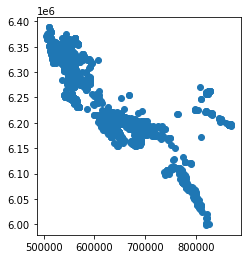

In [49]:
# define wells within structural corridors for test B and C

strCorr = gpd.read_file('data/corridors_shapefiles/StrCorridorsAll.shp')
    
def extract_wells_in_corridors(wells_df, strCorr):
#     strCorr = gpd.read_file('./corridors_shapefiles/StrCorridorsAll.shp')
    
    strCorr = strCorr.set_crs('epsg:26910')
    corridors = strCorr.unary_union

    wells_df = wells_df.to_crs(26910)

    wells_df['isinCorr'] = wells_df.within(corridors)
    wells_df.loc[:,'flagSC'] = np.where(wells_df['isinCorr'] == 1, True, False)
    wells_df_subset = wells_df.loc[wells_df['flagSC'] == True]

    return wells_df_subset

wells_gdf_SC = extract_wells_in_corridors(wells_gdf, strCorr)
wells_gdf_SC.plot()


In [ ]:
scale=10.5

catH = create_synt_EQdf_testH0(realEQnumber, wells_gdf, scale)
catA = create_synt_EQdf_testA(realEQnumber, wells_gdf, scale)
catB = create_synt_EQdf_testB(realEQnumber, wells_gdf_SC, scale)
catC = create_synt_EQdf_testC(realEQnumber, wells_gdf_SC, scale)